<a href="https://colab.research.google.com/github/AlexeyTri/Seminars_Med/blob/main/DeepLearning_sem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# добавить описание GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
# добавить описание LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# добавить описание LabelEncoder
from mlxtend.plotting import plot_decision_regions
# добавить описание Word2Vec
from gensim.models import Word2Vec

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='hist')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('%.1f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Таблица анализа данных, коэффициент корреляции')
    plt.show()

In [ ]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)


In [ ]:
# загружаем полный датасет
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)
raw_table_data.head(10)

subject_id  Count_subj  study_id  cart_id  Healthy_Status eeg_time   \
0    19557662          27  40000017  6848296               0   8:44 AM   
1    18477137          93  40000029  6848296               0   9:54 AM   
2    16598616           3  40000035  6376932               1   9:07 AM   
3    16368287           7  40000079  6214760               1   5:14 PM   
4    18370366           2  40000084  6632385               0   1:52 PM   
5    15606157          55  40000089  6632385               0   2:29 PM   
6    12576058          43  40000115  6852956               1  12:54 PM   
7    14691089           1  40000143  6551957               0  10:01 AM   
8    14144725           7  40000144  6924910               0   7:24 AM   
9    16089780           2  40000152  6919786               0  12:35 PM   

    eeg_date                    report_0  \
0  27.06.2015               Sinus rhythm   
1  27.06.2015               Sinus rhythm   
2  28.06.2015          Sinus tachycardia   
3  15.07.2015               Sinus rhythm   
4  27.09.2015               Sinus rhythm   
5  29.10.2013               Sinus rhythm   
6  23.03.2016               Sinus rhythm   
7  10.12.2016               Sinus rhythm   
8  11.12.2011  Sinus rhythm with PAC(s).   
9  13.12.2011               Sinus rhythm   

                                            report_1  \
0                  Possible right atrial abnormality   
1                  Possible right atrial abnormality   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7                 rSr'(V1) - probable normal variant   
8                                                NaN   
9  Extensive T wave changes may be due to myocard...   

                               report_2  ...                    filtering  \
0                                   NaN  ...  60 Hz notch Baseline filter   
1                                   NaN  ...  60 Hz notch Baseline filter   
2            Normal ECG except for rate  ...  60 Hz notch Baseline filter   
3                            Normal ECG  ...  60 Hz notch Baseline filter   
4                                   NaN  ...              <not specified>   
5                                   NaN  ...              <not specified>   
6                            Normal ECG  ...  60 Hz notch Baseline filter   
7  Low QRS voltages in precordial leads  ...  60 Hz notch Baseline filter   
8                        Borderline ECG  ...  60 Hz notch Baseline filter   
9                                   NaN  ...  60 Hz notch Baseline filter   

  rr_interval p_onset  p_end qrs_onset qrs_end t_end p_axis qrs_axis t_axis  
0         659      40    128       170     258   518     81       77     79  
1         722      40    124       162     246   504     77       75     70  
2         600      40    130       162     244   474     79       72     77  
3         659      40    146       180     254   538     79       66     69  
4         659     368  29999       504     590   868     84       80     77  
5         822     365  29999       499     592   852     26       46     30  
6         952      40    146       198     282   598     24       80     20  
7         923      40    140       188     278   594     26       86     13  
8         952      40    180       196     294   610     59      -17      3  
9        1000      40    156       178     274   584      8      -11     19  

[10 rows x 36 columns]

In [ ]:
#Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

subject_id  Count_subj  study_id  cart_id  eeg_time    eeg_date    report  \
0    19557662          27  40000017  6848296   8:44 AM  27.06.2015  0.013083   
1    18477137          93  40000029  6848296   9:54 AM  27.06.2015  0.013083   
2    16598616           3  40000035  6376932   9:07 AM  28.06.2015  0.031622   
3    16368287           7  40000079  6214760   5:14 PM  15.07.2015  0.019732   
6    12576058          43  40000115  6852956  12:54 PM  23.03.2016  0.019732   

   rr_interval  p_onset  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  \
0          659       40    128        170      258    518      81        77   
1          722       40    124        162      246    504      77        75   
2          600       40    130        162      244    474      79        72   
3          659       40    146        180      254    538      79        66   
6          952       40    146        198      282    598      24        80   

   t_axis  Healthy_Status  
0      79               0  
1      70               0  
2      77               1  
3      69               1  
6      20               1

In [ ]:
# make new dataset from old columns
table_data = full_df_filtered[['report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data.head()

report  rr_interval  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  \
0  0.013083          659    128        170      258    518      81        77   
1  0.013083          722    124        162      246    504      77        75   
2  0.031622          600    130        162      244    474      79        72   
3  0.019732          659    146        180      254    538      79        66   
6  0.019732          952    146        198      282    598      24        80   

   t_axis  Healthy_Status  
0      79               0  
1      70               0  
2      77               1  
3      69               1  
6      20               1

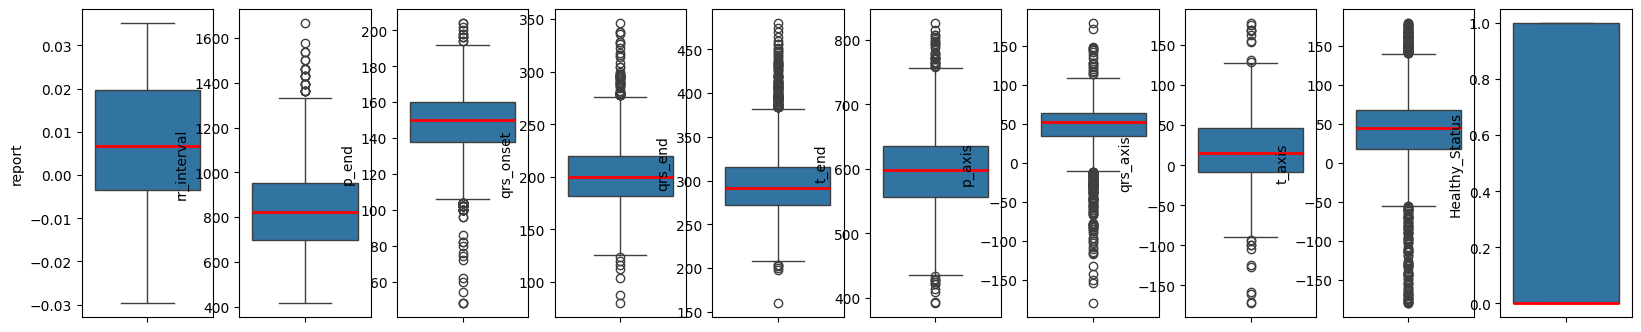

In [ ]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})


In [ ]:
# удаляем аномалии из данных (убрать все значения более 5000)
#table_data = table_data.drop(table_data[table_data['qrs_axis'] > 5000].index)
for i, v in enumerate(table_data):
  table_data = table_data.drop(table_data[table_data.iloc[:,i] > 10000].index)


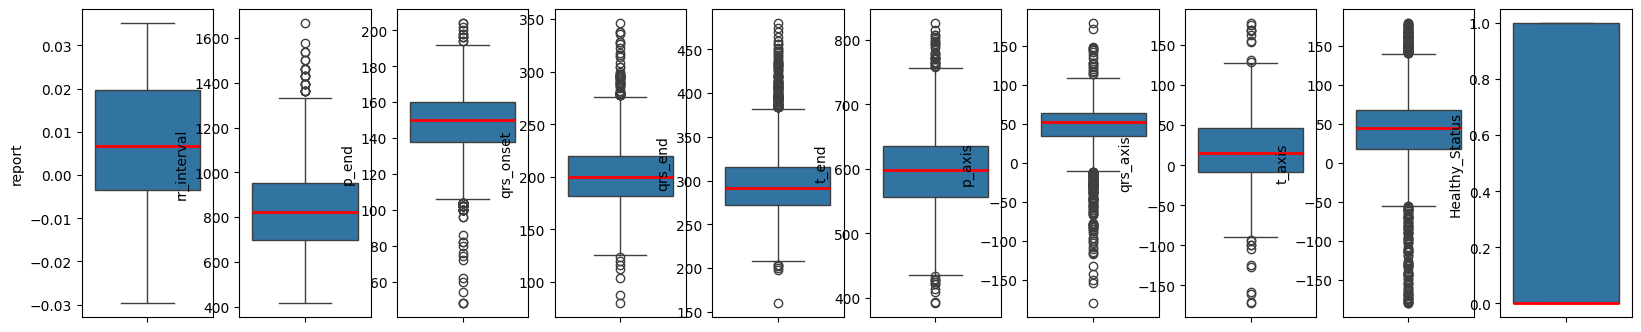

In [ ]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data,
                medianprops={"color": "r", "linewidth": 2})
    plt.tight_layout


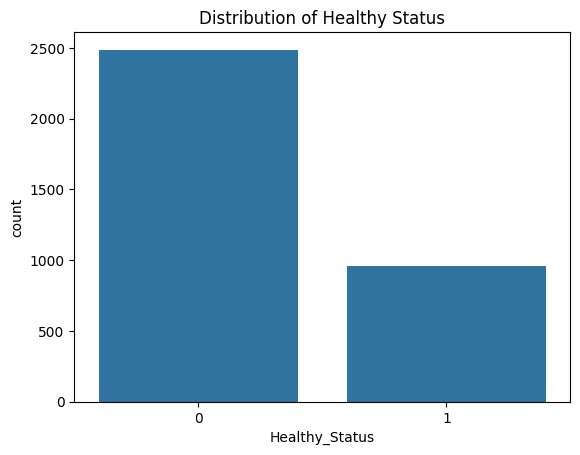

In [ ]:
sns.countplot(data=table_data, x="Healthy_Status")
plt.title("Distribution of Healthy Status")
plt.show()

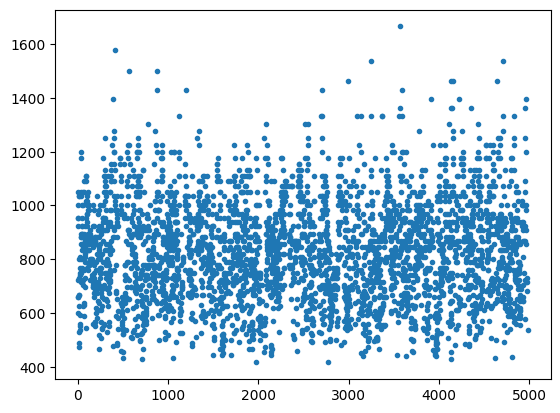

In [ ]:
#example view
plt.plot(table_data['rr_interval'],'.')


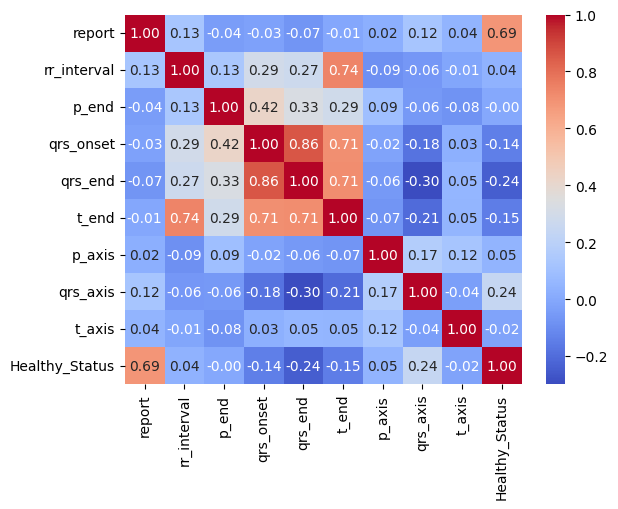

In [ ]:
sns.heatmap(table_data.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()

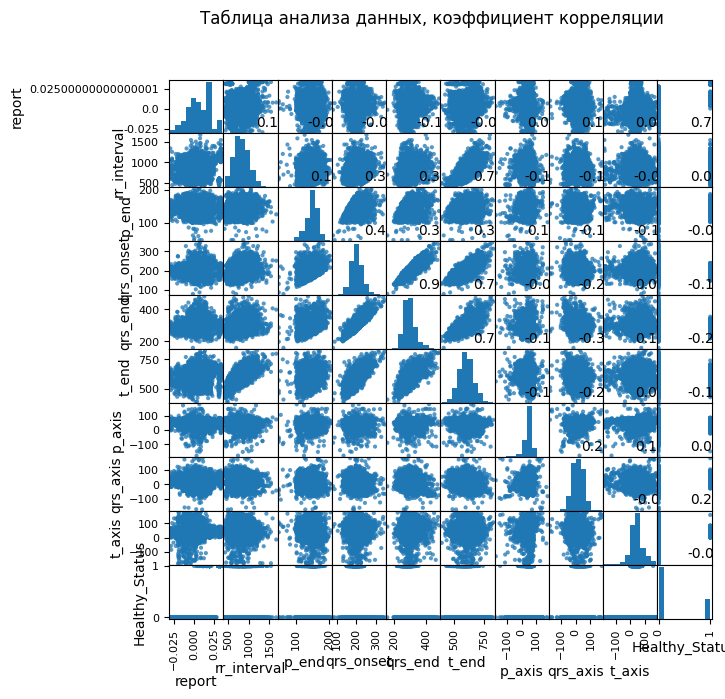

In [ ]:
plotScatterMatrix(table_data, 7, 10)

<Axes: xlabel='rr_interval', ylabel='p_axis'>

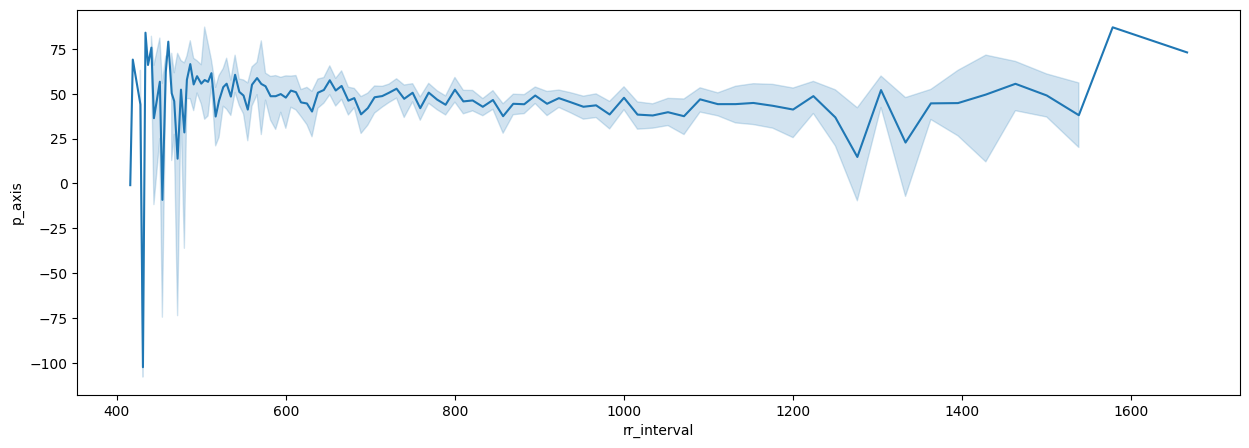

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
#sns.lineplot(x='age',y='debtinc',data=table_data,ax=ax)
sns.lineplot(x='rr_interval',y='p_axis',data=table_data,ax=ax)

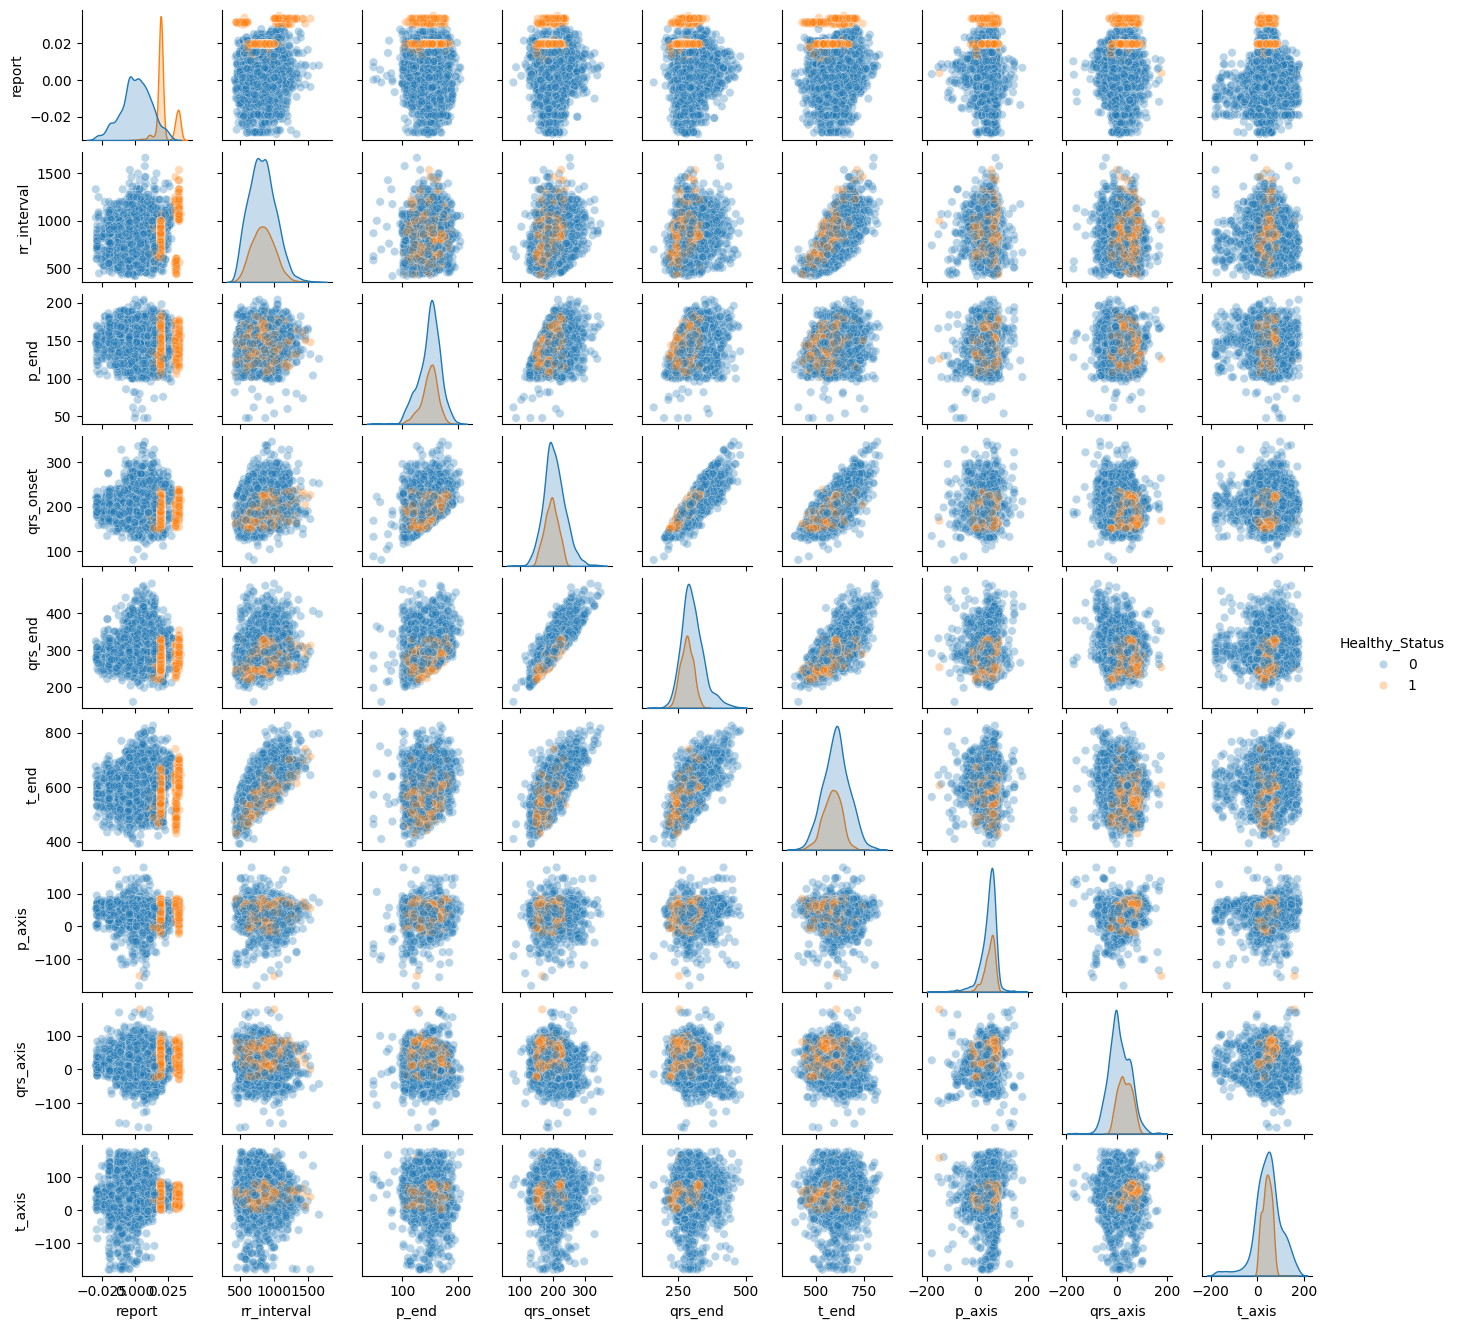

In [ ]:
sns.pairplot(table_data, hue = "Healthy_Status",
             height=1.5,
             plot_kws=dict(alpha=0.3))

<Axes: xlabel='rr_interval', ylabel='qrs_end'>

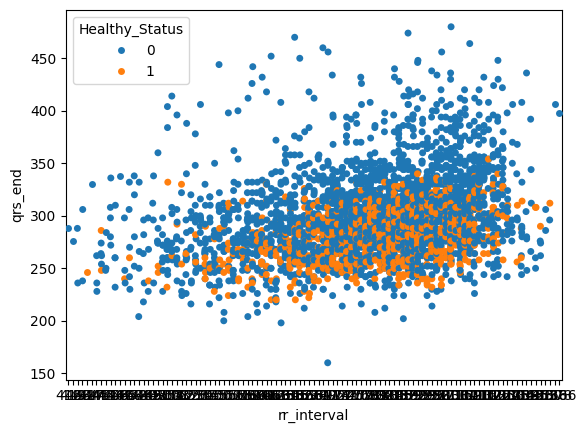

In [ ]:
sns.stripplot(x=table_data['rr_interval'],y=table_data['qrs_end'],
              hue=table_data['Healthy_Status'],jitter=True)

<Axes: xlabel='rr_interval'>

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 58.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


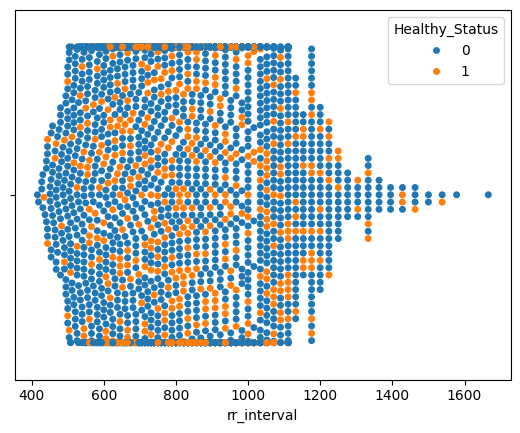

In [ ]:
sns.swarmplot(data=table_data, x="rr_interval", hue="Healthy_Status")

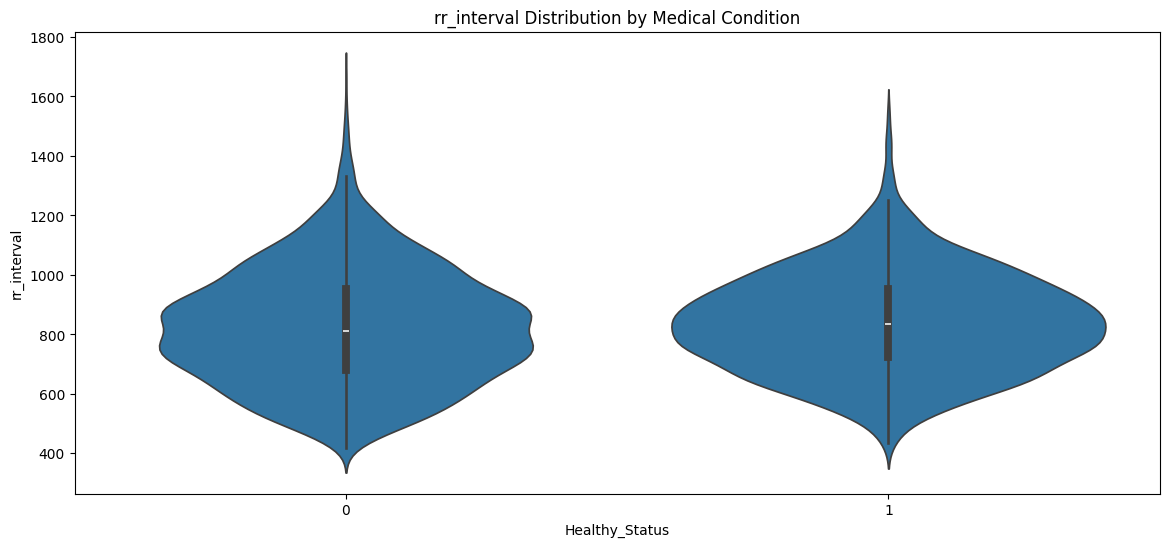

In [ ]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=table_data, y='rr_interval', x='Healthy_Status')
plt.title('rr_interval Distribution by Medical Condition')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [ ]:
table_data_pca = full_df_filtered
table_data_pca = table_data_pca.drop('Healthy_Status', axis = 1)
table_data_pca.columns

Index(['subject_id', 'Count_subj', 'study_id', 'cart_id', 'eeg_time',
       'eeg_date', 'report', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset',
       'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis'],
      dtype='object')

In [ ]:
table_data_pca_new = table_data_pca.drop(['eeg_time', 'eeg_date'], axis=1)

In [ ]:
table_data_pca

subject_id  Count_subj  study_id  cart_id  eeg_time    eeg_date  \
0       19557662          27  40000017  6848296   8:44 AM  27.06.2015   
1       18477137          93  40000029  6848296   9:54 AM  27.06.2015   
2       16598616           3  40000035  6376932   9:07 AM  28.06.2015   
3       16368287           7  40000079  6214760   5:14 PM  15.07.2015   
6       12576058          43  40000115  6852956  12:54 PM  23.03.2016   
...          ...         ...       ...      ...       ...         ...   
4967    19981210          64  40063156  6037973   4:33 PM  25.10.2014   
4969    12711905          10  40063171  6848296   7:20 PM  16.01.2014   
4970    17447497          39  40063182  6672155   2:13 AM  16.01.2014   
4971    18249522          17  40063192  6243470   5:37 AM  16.01.2014   
4989    19268750          31  40063374  6784628   7:54 AM  19.02.2014   

        report  rr_interval  p_onset  p_end  qrs_onset  qrs_end  t_end  \
0     0.013083          659       40    128        170      258    518   
1     0.013083          722       40    124        162      246    504   
2     0.031622          600       40    130        162      244    474   
3     0.019732          659       40    146        180      254    538   
6     0.019732          952       40    146        198      282    598   
...        ...          ...      ...    ...        ...      ...    ...   
4967 -0.004125          909       40    154        210      294    606   
4969  0.015123          714       40    158        224      314    608   
4970  0.015123          731       40    150        208      302    612   
4971  0.015123          681       40    146        204      296    596   
4989  0.001281          535       40    148        218      330    548   

      p_axis  qrs_axis  t_axis  
0         81        77      79  
1         77        75      70  
2         79        72      77  
3         79        66      69  
6         24        80      20  
...      ...       ...     ...  
4967      37        43       7  
4969      47         5      45  
4970      54         8      47  
4971      59        11      53  
4989       1        -1      23  

[3448 rows x 16 columns]

In [ ]:
#cancer = load_breast_cancer()
# Before applying PCA, each feature should be centered (zero mean) and with unit variance
scaled_data = StandardScaler().fit(table_data_pca_new).transform(table_data_pca_new)
pca = PCA(n_components = 2).fit(scaled_data)
# PCA(copy=True, n_components=2, whiten=False)
x_pca = pca.transform(scaled_data)
print(table_data.shape, x_pca.shape)

(3448, 10) (3448, 2)


In [ ]:
percent = pca.explained_variance_ratio_
print(percent)
print(sum(percent))
#To see how much variance is preserved for each dataset.

[0.22209467 0.08841289]
0.3105075601260926


In [ ]:
def pca_explained(X, threshold):
  features = X.shape[1]
  for i in range(2, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    # add all components explained variances
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if percent > threshold:
      break

pca_explained(scaled_data, 0.85)


2 components at 31.05% explained variance
3 components at 39.58% explained variance
4 components at 47.37% explained variance
5 components at 55.06% explained variance
6 components at 62.47% explained variance
7 components at 69.47% explained variance
8 components at 76.27% explained variance
9 components at 82.84% explained variance
10 components at 88.75% explained variance


Text(0, 0.5, 'Second Principal Component')

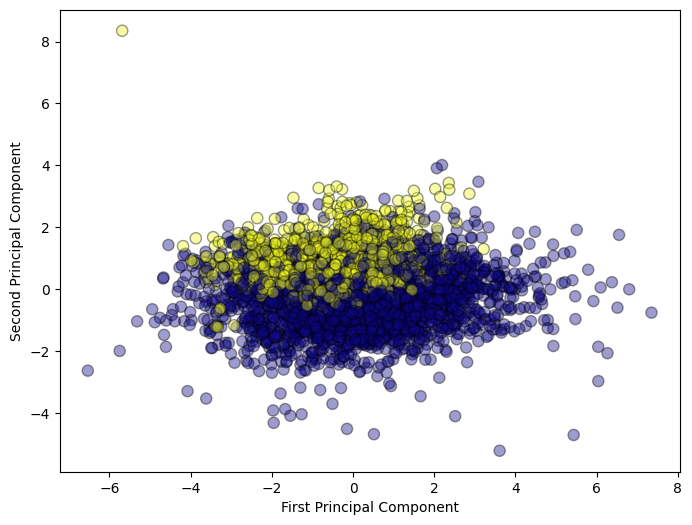

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

<ipython-input-36-b854f9fddf4b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
<ipython-input-36-b854f9fddf4b>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')


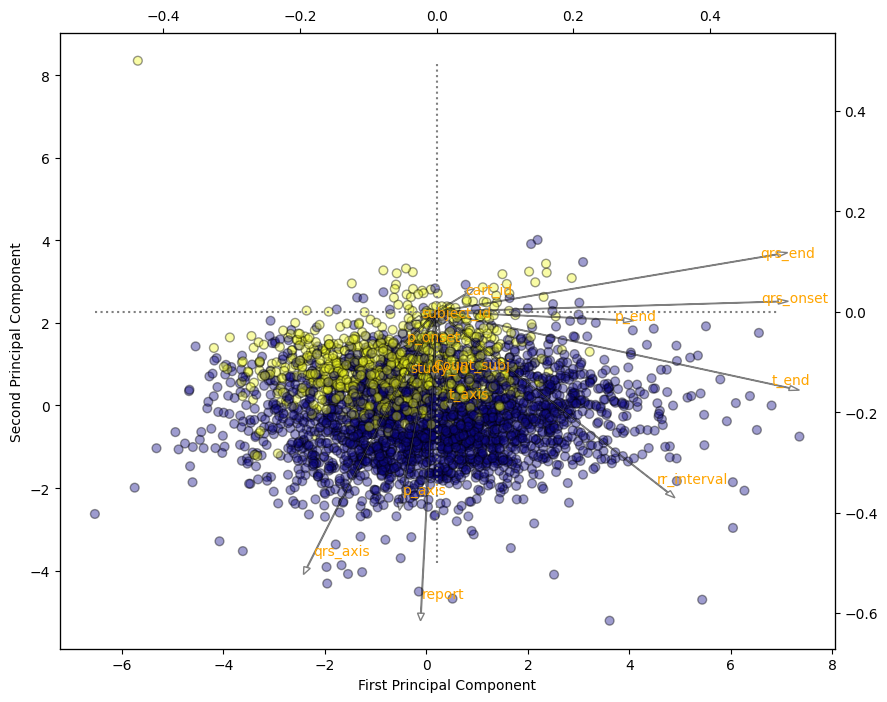

In [ ]:
# put feature values into dataframe
components = pd.DataFrame(pca.components_.T, index=table_data_pca_new.columns, columns= ['PCA1','PCA2'])
# plot size
plt.figure(figsize=(10,8))
# main scatterplot
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'],
            cmap='plasma', alpha=0.4, edgecolors='black', s=40);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
#plt.ylim(15,-15);
#plt.xlim(20,-20);

# individual feature values
ax2 = plt.twinx().twiny();
#ax2.set_ylim(-0.5,0.5);
#ax2.set_xlim(-0.5,0.5);

# reference lines
ax2.hlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
ax2.vlines(0,-0.5,0.5, linestyles='dotted', colors='grey')

# offset for labels
offset = 0.95
# arrow & text
for a, i in enumerate(components.index):
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')


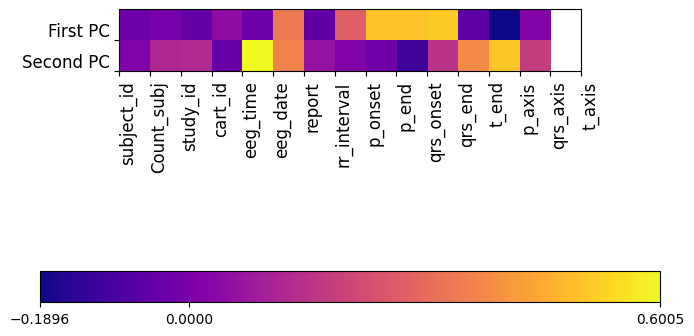

In [ ]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(table_data_pca.columns)
plt.gca().set_xticks(np.arange(-.5, len(feature_names)-1));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left',fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom',fontsize=12);
plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()],pad=0.65);


ML методы
ML: GussianClassifier + описание классов и матрица ошибок

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
table_data.columns

Index(['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
       'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status'],
      dtype='object')

In [ ]:
# set the classification index of table
clf_index = 9

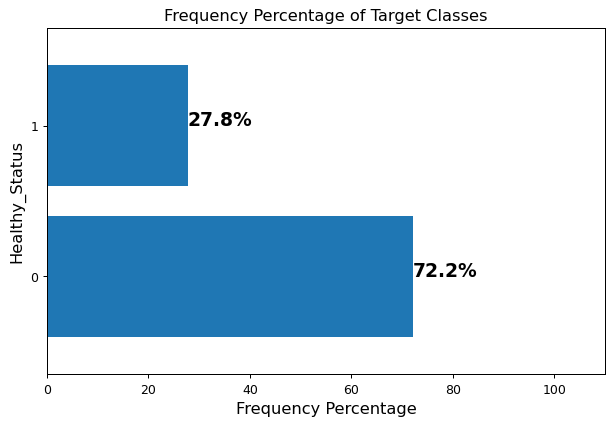

In [ ]:
plt.figure(figsize=(35,20),dpi=90)
# Plot frequency percentages barplot
table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

In [ ]:
# classification variable
y1 = table_data.iloc[:, clf_index]
# input variable
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]

y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values,
                                                        y1.values,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y1.values)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X1.values,
                                                 y1.values,
                                                 test_size=0.3,
                                                 random_state=41,
                                                 stratify=y1.values)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2413, 9)
y_train shape: (2413,)
X_test shape: (1035, 9)
y_test shape: (1035,)


In [ ]:
GussianClassifier = GaussianNB()
GussianClassifier.fit(X1_train,y1_train)
y_pred=GussianClassifier.predict(X_test)
print("===================================> Result <===================================")
print("Accuracy                     = " ,metrics.accuracy_score(y_test,y_pred))
print("F1 Score                     = " ,metrics.f1_score(y_test,y_pred))


===================================> Result <===================================
Accuracy                     =  0.9053140096618357
F1 Score                     =  0.846875


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

              precision    recall  f1-score   support

        True       0.98      0.89      0.93       747
       False       0.77      0.94      0.85       288

    accuracy                           0.91      1035
   macro avg       0.87      0.92      0.89      1035
weighted avg       0.92      0.91      0.91      1035



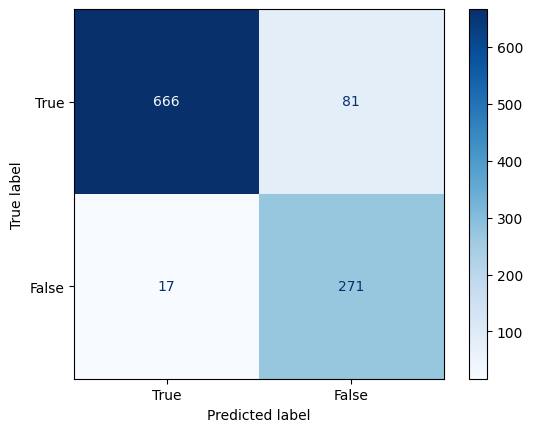

In [ ]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_pred,labels=labels_names, target_names=target_names))
#cm = confusion_matrix(y_test, y_pred,labels=labels_names,normalize='true')
cm = confusion_matrix(y_test, y_pred,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

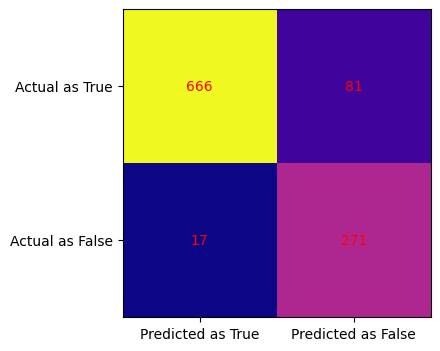

In [ ]:
cm = confusion_matrix(y_test,GussianClassifier.predict(X_test))

fig , ax  = plt.subplots(figsize=(4,4))
ax.imshow(cm, cmap = 'plasma')
ax.grid(False)
ax.xaxis.set(ticks=(0,1),ticklabels=("Predicted as True","Predicted as False"))
ax.yaxis.set(ticks=(0,1),ticklabels=("Actual as True","Actual as False"))
ax.set_ylim(1.5,-0.5)
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm[i,j],ha="center",va="center",color = "red")

AutoML examples
AutoML BlueCast

In [ ]:
!pip install bluecast --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec

In [ ]:
import numpy as np
import pandas as pd
import re


from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig
from bluecast.preprocessing.custom import CustomPreprocessing
from bluecast.general_utils.general_utils import save_to_production, load_for_production

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

In [ ]:
# Убираем из датасета лишние столбцы
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

# Разбиение на обучающую и тестовую выборки

random_seed = 13

# set the classification index of table
clf_index = 9

auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(auto_X, auto_Y, train_size=0.85, random_state=random_seed, stratify=auto_Y)

# Склеиваем признаки и таргеты в один датафрейм (только для обучающей выборки)
auto_train_df = auto_X_train
auto_train_df['Healthy_Status'] = auto_Y_train

# Создаем и обучаем модель
#automl = BlueCast(class_problem="binary")
#automl.fit(auto_train_df, target_col="Healthy_Status")

In [ ]:
#  Пример загрузки данных
table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)

df = table_data

# Проверка формы набора данных
print('исходный набор данных: ',df.shape)

# Инициализация начального числа для генераторов случайных чисел
seed = 13

# Создание обучающего набора с помощью выборки pandas — видимый набор данных
train_dataset = autoML_df.sample(frac=.8, random_state=seed)
#knowledge.reset_index(inplace=True, drop=True)
print('выделяем из исходного набора данныз базу для обучения: ', train_dataset.shape)

# Использование образцов, недоступных в обучающем наборе, в качестве будущего или невидимого набора данных
test_dataset = autoML_df.drop(train_dataset.index)
#payload.reset_index(inplace=True, drop=True)
print('набор данных для проверки: ',test_dataset.shape)

исходный набор данных:  (5000, 36)
выделяем из исходного набора данныз базу для обучения:  (2758, 10)
набор данных для проверки:  (690, 10)


In [ ]:
# Предобрабатываем данные

full_df = df

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
#columns_to_filter = ['rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = full_df[(full_df[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

full_df_filtered.head()

subject_id  Count_subj  study_id  cart_id  eeg_time    eeg_date  \
0    19557662          27  40000017  6848296   8:44 AM  27.06.2015   
1    18477137          93  40000029  6848296   9:54 AM  27.06.2015   
2    16598616           3  40000035  6376932   9:07 AM  28.06.2015   
3    16368287           7  40000079  6214760   5:14 PM  15.07.2015   
6    12576058          43  40000115  6852956  12:54 PM  23.03.2016   

                                              report     bandwidth  \
0  Sinus rhythm Possible right atrial abnormality...  0.005-150 Hz   
1  Sinus rhythm Possible right atrial abnormality...  0.005-150 Hz   
2       Sinus tachycardia Normal ECG except for rate  0.005-150 Hz   
3                            Sinus rhythm Normal ECG  0.005-150 Hz   
6                            Sinus rhythm Normal ECG  0.005-150 Hz   

                     filtering  rr_interval  p_onset  p_end  qrs_onset  \
0  60 Hz notch Baseline filter          659       40    128        170   
1  60 Hz notch Baseline filter          722       40    124        162   
2  60 Hz notch Baseline filter          600       40    130        162   
3  60 Hz notch Baseline filter          659       40    146        180   
6  60 Hz notch Baseline filter          952       40    146        198   

   qrs_end  t_end  p_axis  qrs_axis  t_axis  Healthy_Status  
0      258    518      81        77      79               0  
1      246    504      77        75      70               0  
2      244    474      79        72      77               1  
3      254    538      79        66      69               1  
6      282    598      24        80      20               1

In [ ]:
full_df_filtered['report']

0       Sinus rhythm Possible right atrial abnormality...
1       Sinus rhythm Possible right atrial abnormality...
2            Sinus tachycardia Normal ECG except for rate
3                                 Sinus rhythm Normal ECG
6                                 Sinus rhythm Normal ECG
                              ...                        
4967    Sinus rhythm Anterior T wave changes are nonsp...
4969    Sinus rhythm Possible left atrial abnormality ...
4970    Sinus rhythm Possible left atrial abnormality ...
4971    Sinus rhythm Possible left atrial abnormality ...
4989    Sinus tachycardia - premature ventricular cont...
Name: report, Length: 3448, dtype: object

In [ ]:
target = 'Healthy_Status'

In [ ]:
from bluecast.preprocessing.feature_types import FeatureTypeDetector

feat_type_detector = FeatureTypeDetector()
train_data = feat_type_detector.fit_transform_feature_types(train_dataset)

len(feat_type_detector.num_columns)

10

In [ ]:
train_data

report  rr_interval  p_end  qrs_onset  qrs_end  t_end  p_axis  \
287   0.008488          952    100        194      358    680      76   
1332  0.000478          952    160        224      296    606     -13   
4466  0.000738          638    168        200      290    556      17   
3340 -0.003207          659    122        178      258    514      57   
1331  0.002501          909    160        224      304    626      34   
...        ...          ...    ...        ...      ...    ...     ...   
3675  0.001140          937    170        202      290    642      36   
825   0.001265          800    146        198      296    600     147   
4334 -0.010305          535    154        166      274    498      53   
2986  0.006954          612    156        196      274    548      45   
3617  0.019732          937    144        180      266    560      71   

      qrs_axis  t_axis  Healthy_Status  
287        -48      53               0  
1332        24      42               0  
4466        24      42               0  
3340        48      33               0  
1331        13      31               0  
...        ...     ...             ...  
3675        50      37               0  
825        129     130               0  
4334       -19      51               0  
2986         0      34               0  
3617        80      71               1  

[2758 rows x 10 columns]

In [ ]:
#Automatic feature type detection from BlueCast
print(feat_type_detector.date_columns)

[]


In [ ]:
feat_type_detector.num_columns

['rr_interval',
 'p_end',
 'qrs_onset',
 'qrs_end',
 't_end',
 'p_axis',
 'qrs_axis',
 't_axis',
 'Healthy_Status',
 'report']

In [ ]:
feat_type_detector.cat_columns

[]

In [ ]:
from bluecast.eda.analyse import (
    bi_variate_plots,
    correlation_heatmap,
    correlation_to_target,
    plot_pca,
    plot_theil_u_heatmap,
    plot_tsne,
    univariate_plots,
    check_unique_values,
    plot_null_percentage
)

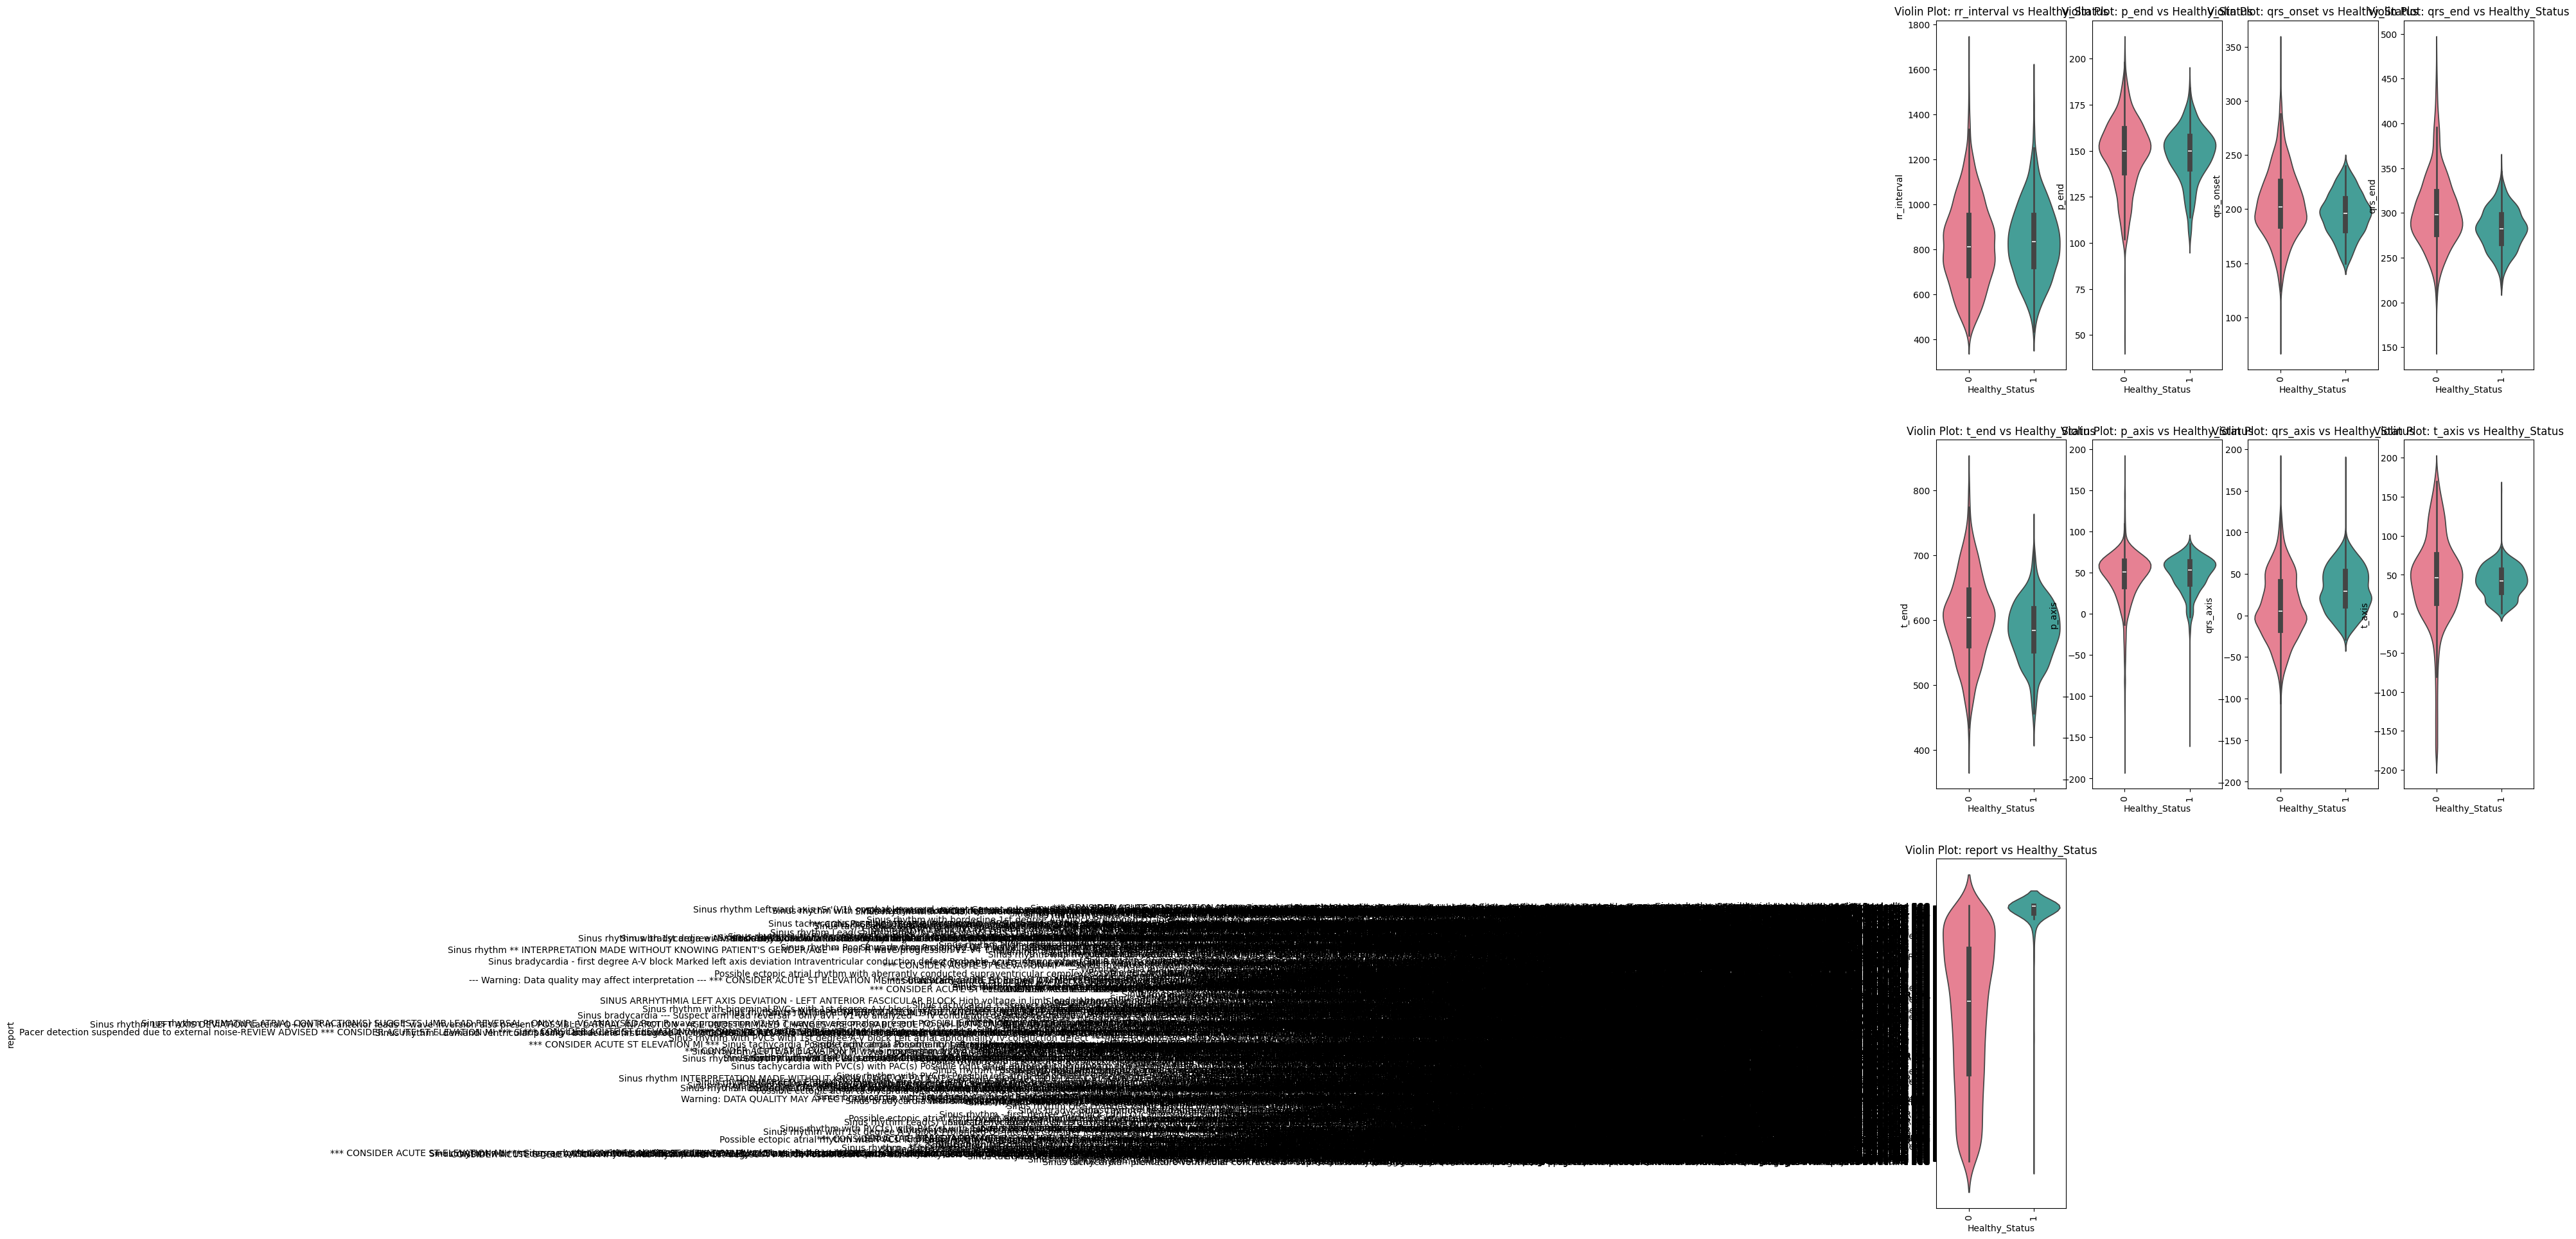

In [ ]:
bi_variate_plots(
        full_df_filtered.loc[
            :, feat_type_detector.num_columns
        ],
        target,
    )

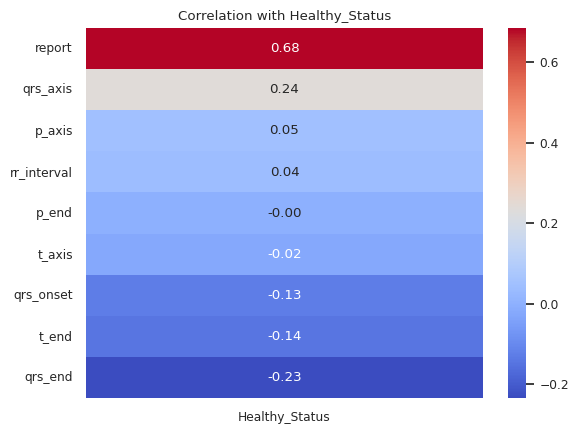

In [ ]:
# show correlation to target
correlation_to_target(
    train_data.loc[:, feat_type_detector.num_columns],
      target,
      )

In [ ]:
#no_correlation = ["p_axis", "p_end", "t_axis"]

no_correlation = ["p_onset", "subject_id", "p_end", "cart_id", "Count_subj"]

train = full_df_filtered.drop(no_correlation, axis=1)
test = full_df_filtered.drop(no_correlation, axis=1)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3448 entries, 0 to 4989
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   study_id        3448 non-null   int64 
 1   eeg_time        3448 non-null   object
 2   eeg_date        3448 non-null   object
 3   report          3448 non-null   object
 4   bandwidth       3448 non-null   object
 5   filtering       3448 non-null   object
 6   rr_interval     3448 non-null   int64 
 7   qrs_onset       3448 non-null   int64 
 8   qrs_end         3448 non-null   int64 
 9   t_end           3448 non-null   int64 
 10  p_axis          3448 non-null   int64 
 11  qrs_axis        3448 non-null   int64 
 12  t_axis          3448 non-null   int64 
 13  Healthy_Status  3448 non-null   int64 
dtypes: int64(9), object(5)
memory usage: 533.1+ KB


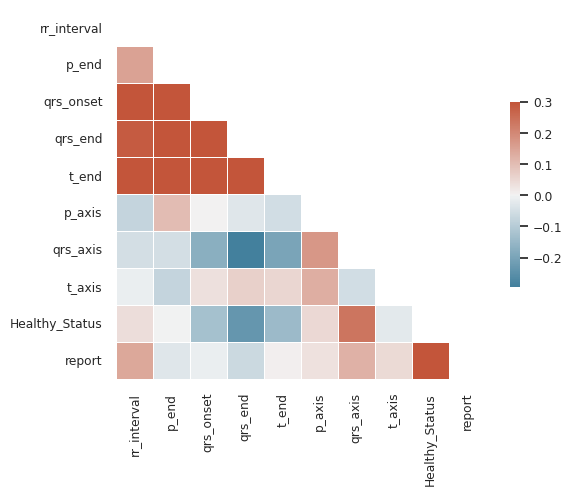

In [ ]:
correlation_heatmap(train_data.loc[
            :, feat_type_detector.num_columns])

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0.5840742 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
 -0.22672085]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
 -0.73200243]' has dtype incompatible with int64, please explicitly c

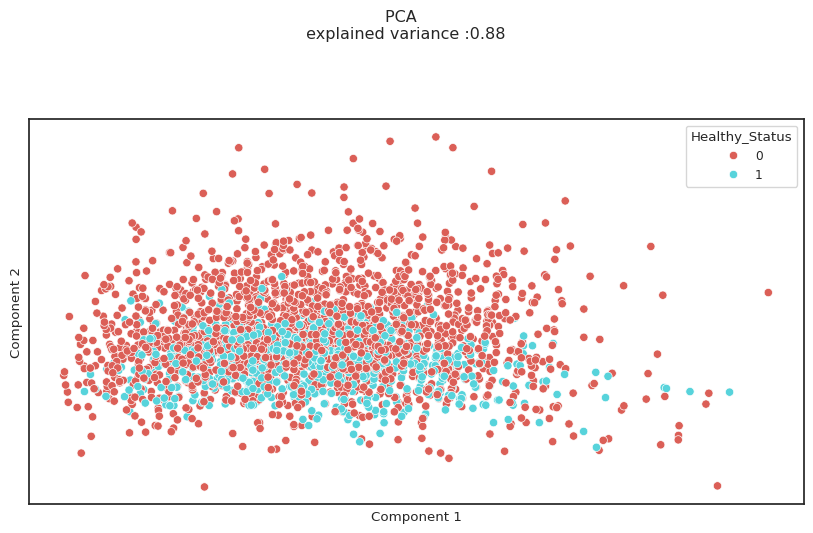

In [ ]:
# show feature space after principal component analysis
plot_pca(train_data.loc[
            :, feat_type_detector.num_columns
        ].fillna(0), target)

You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 -0.08242886  0.31505162  1.26041058 -1.5380668   0.54064864 -1.02778782
  1.26041058  0.9649859  -0.01797256  0.17539632  0.9649859  -0.30802588
 -2.19337245 -0.51750883  0.62121901 -0.2543123   1.26041058 -0.01797256
 -1.30172706 -1.20504262 -0.61419327  1.06167034 -0.14

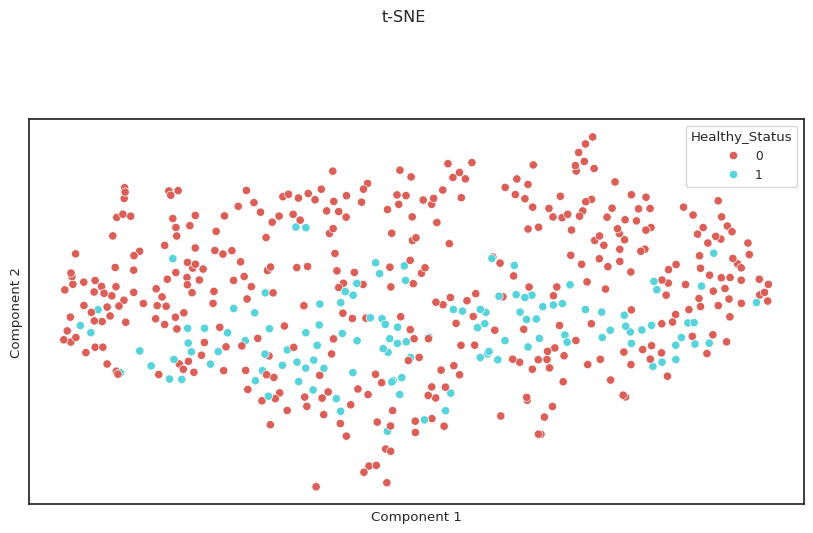

In [ ]:
# show feature space after t-SNE
plot_tsne(train_data.loc[
            :, feat_type_detector.num_columns
        ].sample(500, random_state=42).fillna(0), target, perplexity=30, random_state=0)


In [ ]:
from bluecast.eda.data_leakage_checks import (
    detect_categorical_leakage,
    detect_leakage_via_correlation,
)


In [ ]:
# Detect leakage of numeric columns based on correlation
numresult = detect_leakage_via_correlation(
        train_data.loc[:, feat_type_detector.num_columns].fillna(0), target, threshold=0.9 # target column is part of detected numerical columns here
    )

No leakage has been detected


In [ ]:
# Detect leakage of categorical columns based on Theil's U
result = detect_categorical_leakage(
        train_data.loc[:, feat_type_detector.cat_columns + [target]], target, threshold=0.9
    )

No leakage has been detected


In [ ]:
# Группировка

full_df = full_df.sort_values(by='subject_id', ascending=True)
full_df = full_df["subject_id"].unique()

In [ ]:
# Превращаем столбец с текстовым отчетом в число с помощью Word2Vec
from gensim.models import Word2Vec
# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

subject_id  Count_subj  study_id  cart_id  eeg_time    eeg_date    report  \
0    19557662          27  40000017  6848296   8:44 AM  27.06.2015  0.008146   
1    18477137          93  40000029  6848296   9:54 AM  27.06.2015  0.008146   
2    16598616           3  40000035  6376932   9:07 AM  28.06.2015  0.028811   
3    16368287           7  40000079  6214760   5:14 PM  15.07.2015  0.017806   
6    12576058          43  40000115  6852956  12:54 PM  23.03.2016  0.017806   

      bandwidth                    filtering  rr_interval  p_onset  p_end  \
0  0.005-150 Hz  60 Hz notch Baseline filter          659       40    128   
1  0.005-150 Hz  60 Hz notch Baseline filter          722       40    124   
2  0.005-150 Hz  60 Hz notch Baseline filter          600       40    130   
3  0.005-150 Hz  60 Hz notch Baseline filter          659       40    146   
6  0.005-150 Hz  60 Hz notch Baseline filter          952       40    146   

   qrs_onset  qrs_end  t_end  p_axis  qrs_axis  t_axis  Healthy_Status  
0        170      258    518      81        77      79               0  
1        162      246    504      77        75      70               0  
2        162      244    474      79        72      77               1  
3        180      254    538      79        66      69               1  
6        198      282    598      24        80      20               1

In [ ]:
# Применяем BlueCast

# Импорт библиотеки
from bluecast.blueprints.cast import BlueCast

# Убираем из датасета лишние столбцы
autoML_df = full_df_filtered[['report','Count_subj', 'rr_interval', 'p_end',  'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

auto_X = autoML_df.iloc[:, :autoML_df.shape[1]-1] # Признаки
auto_Y = autoML_df.iloc[:, [autoML_df.shape[1]-1]] # Таргеты

# Первое разбиние: 80% (тренировочные + валидационные) and 20% (тестовые)
auto_X_model, auto_X_test, auto_Y_model, auto_Y_test = train_test_split(auto_X, auto_Y, test_size=0.2, random_state=1828)

# Второе разбиение: 75% (тренировочные) and 25% (валидационные)
auto_X_train, auto_X_val, auto_Y_train, auto_Y_val = train_test_split(auto_X_model, auto_Y_model, test_size=0.25, random_state=2900)

# Склеиваем признаки и таргеты в один датафрейм (только для обучающей выборки)
auto_train_df = auto_X_train
auto_train_df['Healthy_Status'] = auto_Y_train

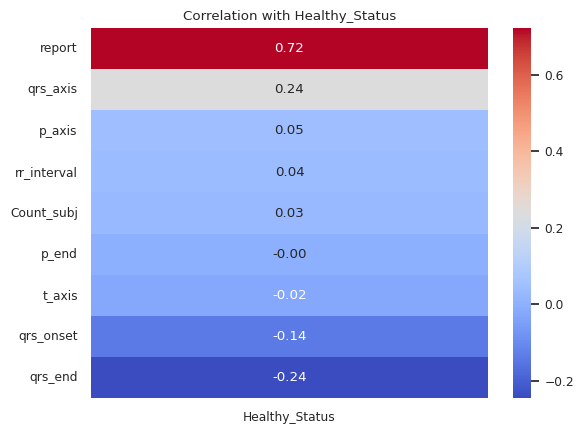

In [ ]:
correlation_to_target(autoML_df,target)

In [ ]:
eval_size = 4500

full_df_filtered = full_df_filtered[['report', 'rr_interval', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

train_eval = full_df_filtered.tail(eval_size)
train_eval = train_eval.reset_index(drop=True)
target_eval = train_eval.pop('Healthy_Status')

train = full_df_filtered.head(len(auto_train_df.index) - eval_size)
train = full_df_filtered.reset_index(drop=True)
target_eval = target_eval.iloc[train_eval.index]

train_eval.head()

report  rr_interval  qrs_onset  qrs_end  p_axis  qrs_axis  t_axis
0  0.008146          659        170      258      81        77      79
1  0.008146          722        162      246      77        75      70
2  0.028811          600        162      244      79        72      77
3  0.017806          659        180      254      79        66      69
4  0.017806          952        198      282      24        80      20

In [ ]:
auto_X_train = auto_X_train.reset_index(drop=True)
auto_X_val = auto_X_val.reset_index(drop=True)
auto_Y_val = auto_Y_val.reset_index(drop=True)
auto_Y_val = auto_Y_val.astype('int64')

In [ ]:
auto_X_model = auto_X_model.reset_index(drop=True)
auto_Y_model = auto_Y_model.reset_index(drop=True)

In [ ]:
automl = BlueCast(class_problem="binary")

automl.conf_training.hyperparameter_tuning_rounds = 20
automl.conf_training.calculate_shap_values = False
automl.conf_training.use_full_data_for_final_model = False

2024-12-22 09:40:34,551 - root - INFO - BlueCast blueprint initialized.


In [ ]:
autoML_df

report  Count_subj  rr_interval  p_end  qrs_onset  qrs_end  p_axis  \
0     0.008146          27          659    128        170      258      81   
1     0.008146          93          722    124        162      246      77   
2     0.028811           3          600    130        162      244      79   
3     0.017806           7          659    146        180      254      79   
6     0.017806          43          952    146        198      282      24   
...        ...         ...          ...    ...        ...      ...     ...   
4967 -0.009049          64          909    154        210      294      37   
4969  0.009153          10          714    158        224      314      47   
4970  0.009153          39          731    150        208      302      54   
4971  0.009153          17          681    146        204      296      59   
4989 -0.002255          31          535    148        218      330       1   

      qrs_axis  t_axis  Healthy_Status  
0           77      79               0  
1           75      70               0  
2           72      77               1  
3           66      69               1  
6           80      20               1  
...        ...     ...             ...  
4967        43       7               0  
4969         5      45               0  
4970         8      47               0  
4971        11      53               0  
4989        -1      23               0  

[3448 rows x 10 columns]

In [ ]:
automl.fit_eval(
    df=autoML_df,
    df_eval=autoML_df.drop('Healthy_Status', axis=1),
    target_eval=autoML_df['Healthy_Status'],
    target_col="Healthy_Status",
)

In [ ]:
# Проверяем, как обучилась наша autoML модель

# Предсказываем
y_probs, y_classes = automl.predict(auto_X_test)

# Импортируем библиотеки для вычисления точности
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# Вычисляем F1-меру с помощью матрицы ошибок
cm = confusion_matrix(auto_Y_test, y_classes)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
roc_auc = roc_auc_score(auto_Y_test, y_probs)

# Выводим матрицу ошибок, F1-меру и ROC AUC
print("Confusion matrix:", cm)
print("F1-Score:", f1_score)
print("ROC AUC:", roc_auc)

AutoML Fedot